### Импортируем библиотеки

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
plt.rcParams['figure.figsize'] = [22, 11]

### Выполним запрос к бд и посмотрим на данные

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230320',
    'user':'student', 
    'password':'dpo_python_2020'
}

query = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-02' and '2023-03-08'
    and exp_group in (0,1,2,3)
GROUP BY exp_group, user_id
'''

In [4]:
df = ph.read_clickhouse(query, connection=connection)

In [5]:
df.head(10)

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,3,123580,13,48,0.270833
3,2,131473,14,134,0.104478
4,2,32420,26,128,0.203125
5,2,24239,40,90,0.444444
6,0,30319,21,110,0.190909
7,1,27443,2,29,0.068966
8,3,118359,7,38,0.184211
9,1,27131,12,89,0.134831


In [6]:
df.groupby('exp_group').ctr.count().reset_index()

,exp_group,ctr
0,0,9999
1,1,10079
2,2,9952
3,3,10049


### Посчитаем CTR в контрольных группах

In [7]:
ctr_control1=sum(df[df.exp_group == 1].likes) / sum(df[df.exp_group == 1].views)

In [8]:
ctr_control0=sum(df[df.exp_group == 0].likes) / sum(df[df.exp_group == 0].views)

In [9]:
ctr_control0, ctr_control1

(0.20823612262916305, 0.20802680490126244)

### Напишем функцию для вычисления метрики, разделим данные для работы

In [10]:
def get_linearized_likes(user_likes, user_views, ctr_control):
    linearized_like = user_likes - ctr_control * user_views
    return linearized_like

In [11]:
group12 = df[(df.exp_group == 1) | (df.exp_group == 2)].copy()
group03 = df[(df.exp_group == 0) | (df.exp_group == 3)].copy()

### Проведем первый эксперимент с группами 1 и 2 (1 группа контрольная). Сравним данные t-теста на линеаризованных лайках и обычном ctr

In [12]:
group12['linearized_like'] = group12.apply(lambda x: get_linearized_likes(x['likes'], x['views'], ctr_control1), axis=1)

<AxesSubplot:xlabel='linearized_like', ylabel='Count'>

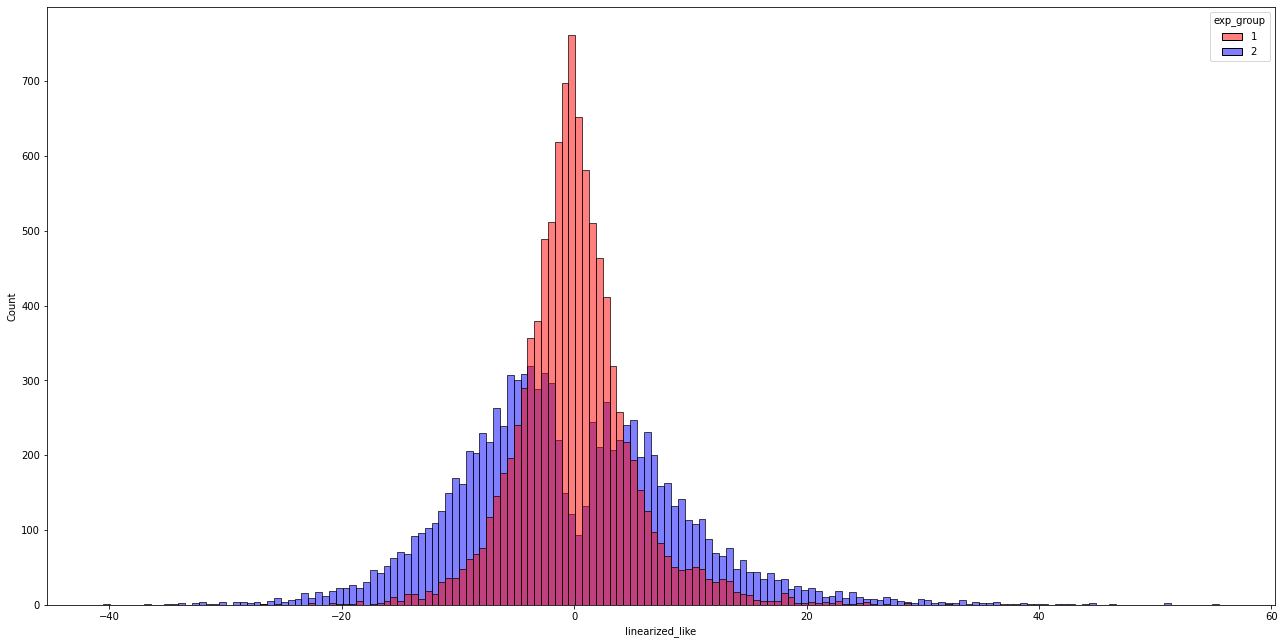

In [13]:
sns.histplot(data = group12, 
              x='linearized_like', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [14]:
stats.ttest_ind(group12[group12.exp_group == 1].linearized_like,
                group12[group12.exp_group == 2].linearized_like,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775972, pvalue=9.439432187037712e-10)

In [15]:
stats.ttest_ind(group12[group12.exp_group == 1].ctr,
                group12[group12.exp_group == 2].ctr)

Ttest_indResult(statistic=0.7116545895251319, pvalue=0.4766869824114077)

### Вывод: при использовании метрики линеаризованных лайков мы сразу видим что группы отличаются, при этом т-тест CTR показывает что группы равны (из-за выбросов, это мы знаем с предыдущего урока

### Проведем второй эксперимент, с группами 0 и 3 (0 группа контрольная)

In [16]:
group03['linearized_like'] = group03.apply(lambda x: get_linearized_likes(x['likes'], x['views'], ctr_control0), axis=1)

<AxesSubplot:xlabel='linearized_like', ylabel='Count'>

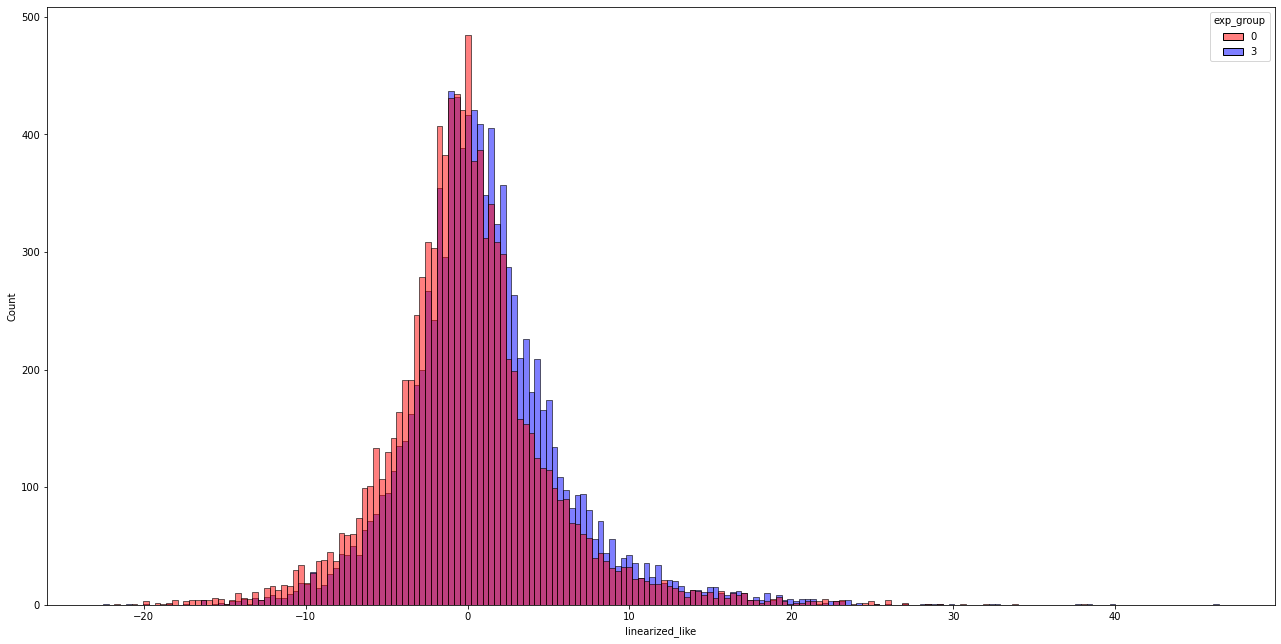

In [17]:
sns.histplot(data = group03, 
              x='linearized_like', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [18]:
stats.ttest_ind(group03[group03.exp_group == 0].linearized_like,
                group03[group03.exp_group == 3].linearized_like,
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

In [19]:
stats.ttest_ind(group03[group03.exp_group == 0].ctr,
                group03[group03.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

## Во втором эксперименте при т-тесте линеаризованных лайков p-value меньше чем при т-тест обычного CTR - чувствительность теста выросла